<a href="https://colab.research.google.com/github/bhuvaneswarignanasekar/chatbot-Deep-learning-/blob/main/Deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Concatenate
from keras.models import Model
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
#import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.33.93.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.93.66:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
import os

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-05-04 02:02:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-04 02:02:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-04 02:02:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# dataset processing

In [ ]:
df=pd.read_excel("/content/cleaned_data.xlsx")
df.head()

,Unnamed: 0,message,response
0,0,hi there,NaN
1,1,Hello!,Hi! How are you?
2,2,Hi! How are you?,Not bad! And You?
3,3,Not bad! And You?,I'm doing well. Just got engaged to my high sc...
4,4,I'm doing well. Just got engaged to my high sc...,Wowowowow! Congratulations! Is she pretty?


In [ ]:
df.columns

Index(['Unnamed: 0', 'message', 'response'], dtype='object')

In [ ]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [ ]:
df.to_csv('/content/cleaned_data.csv')

In [ ]:
data = pd.DataFrame()

In [ ]:
data['question']=df['message']
data['answer']=df['response']

In [ ]:
data.to_excel("/content/data.xlsx")

In [ ]:
print(df.shape)
print("="*60)
print(df.info())
print("="*60)
df.describe()

(13732, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13732 entries, 0 to 13731
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   message   13732 non-null  object
 1   response  13512 non-null  object
dtypes: object(2)
memory usage: 214.7+ KB
None


,message,response
count,13732,13512
unique,10063,10282
top,Hi,what do you do for a living ?
freq,355,386


In [ ]:
print(df.isnull().sum())
print('\n')
print(df.isnull().any())

message       0
response    220
dtype: int64


message     False
response     True
dtype: bool


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.loc[55:60,:]

,message,response
55,She 's pretty good. She' s my idol.,"Yeah, she is hot! And what about Iggy Pop?"
56,"Yeah, she is hot! And what about Iggy Pop?",I love that band! They 're my favorite. What d...
57,I love that band! They 're my favorite. What d...,I'm software developer. And you?
58,I'm software developer. And you?,I am retired. I used to be a programmer. What ...
59,I am retired. I used to be a programmer. What ...,Conversational AI and chat bots. If you were b...
60,Conversational AI and chat bots. If you were b...,"Oh, wow! That 's awesome! 🙂"


In [ ]:
stop_words = set(stopwords.words('english'))
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

#remove_stop = True for questions
#remove_stop = False for answers
def preprocess_text(text,remove_stop):
    text = text.lower()
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()])
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    if remove_stop == True:
        text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([word for word in text.split()])
    return text

In [ ]:
df.message = df.message.apply(preprocess_text,remove_stop=False)
df.response = df.response.apply(preprocess_text,remove_stop=False)
df.loc[55:60,:]

,message,response
55,she s pretty good she s my idol,yeah she is hot and what about iggy pop
56,yeah she is hot and what about iggy pop,i love that band they re my favorite what do y...
57,i love that band they re my favorite what do y...,i am software developer and you
58,i am software developer and you,i am retired i used to be a programmer what ki...
59,i am retired i used to be a programmer what ki...,conversational ai and chat bots if you were bo...
60,conversational ai and chat bots if you were bo...,oh wow that s awesome


In [ ]:
df['decoder_input'] = df.response.apply(lambda x: 'sos '+x)
df['decoder_label'] = df.response.apply(lambda x: x+' eo>')
df.head()

,message,response,decoder_input,decoder_label
1,hello,hi how are you,sos hi how are you,hi how are you eo>
2,hi how are you,not bad and you,sos not bad and you,not bad and you eo>
3,not bad and you,i am doing well just got engaged to my high sc...,sos i am doing well just got engaged to my hig...,i am doing well just got engaged to my high sc...
4,i am doing well just got engaged to my high sc...,wowowowow congratulations is she pretty,sos wowowowow congratulations is she pretty,wowowowow congratulations is she pretty eo>
5,wowowowow congratulations is she pretty,she s pretty cute she invited me to dinner ton...,sos she s pretty cute she invited me to dinner...,she s pretty cute she invited me to dinner ton...


In [ ]:
encoder_input = np.array(df.message)
decoder_input = np.array(df.decoder_input)
decoder_label = np.array(df.decoder_label)

n_rows = df.shape[0]
print(f"{n_rows} rows")

indices = np.arange(n_rows)
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_label = decoder_label[indices]

train_size = 0.9

train_encoder_input = encoder_input[:int(n_rows*train_size)]
train_decoder_input = decoder_input[:int(n_rows*train_size)]
train_decoder_label = decoder_label[:int(n_rows*train_size)]

test_encoder_input = encoder_input[int(n_rows*train_size):]
test_decoder_input = decoder_input[int(n_rows*train_size):]
test_decoder_label = decoder_label[int(n_rows*train_size):]

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

13512 rows
(12160,)
(12160,)
(12160,)
(1352,)
(1352,)
(1352,)


In [ ]:
q_tok = Tokenizer()
q_tok.fit_on_texts(train_encoder_input)
print(len(q_tok.word_counts))

a_tok = Tokenizer()
a_tok.fit_on_texts(train_decoder_input)
a_tok.fit_on_texts(train_decoder_label)
print(len(a_tok.word_counts))

train_encoder_input = q_tok.texts_to_sequences(train_encoder_input)
test_encoder_input = q_tok.texts_to_sequences(test_encoder_input)

train_decoder_input = a_tok.texts_to_sequences(train_decoder_input)
test_decoder_input = a_tok.texts_to_sequences(test_decoder_input)

train_decoder_label = a_tok.texts_to_sequences(train_decoder_label)
test_decoder_label = a_tok.texts_to_sequences(test_decoder_label)

question_word_size = len(q_tok.word_counts)
question_vocab_size = question_word_size+1

answer_word_size = len(a_tok.word_counts)
answer_vocab_size = answer_word_size+1

3670
3659


maximum question sequence length >> 298
maximum answer sequence length >> 299


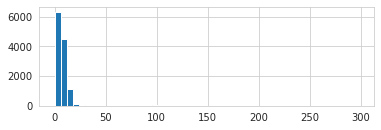

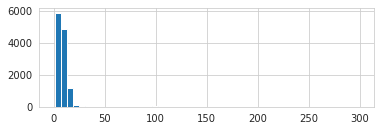

In [ ]:
question_lengths = [len(s) for s in train_encoder_input]
print(f"maximum question sequence length >> {np.max(question_lengths)}")

answer_lengths = [len(s) for s in train_decoder_input]
print(f"maximum answer sequence length >> {np.max(answer_lengths)}")

plt.subplot(2,1,1)
plt.hist(question_lengths,bins=50)
plt.show()

plt.subplot(2,1,2)
plt.hist(answer_lengths,bins=50)
plt.show()

In [ ]:
train_encoder_input = pad_sequences(train_encoder_input,padding='post')
train_decoder_input = pad_sequences(train_decoder_input,padding='post')
train_decoder_label = pad_sequences(train_decoder_label,padding='post')

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

question_sequence_size = train_encoder_input.shape[1]
answer_sequence_size = train_decoder_input.shape[1]

test_encoder_input = pad_sequences(test_encoder_input,padding='post',maxlen=question_sequence_size)
test_decoder_input = pad_sequences(test_decoder_input,padding='post',maxlen=answer_sequence_size)
test_decoder_label = pad_sequences(test_decoder_label,padding='post',maxlen=answer_sequence_size)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

(12160, 298)
(12160, 299)
(12160, 299)
(1352, 298)
(1352, 299)
(1352, 299)


# model encoder decoder without attention

In [ ]:
#trainer model
embedding_size=256
hidden_size = 256

encoder_input = Input(shape=[question_sequence_size])
# encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[question_embedding_matrix])
encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)

lstm1 = Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output1,_,_,_,_ = lstm1(encoder_embedded)
lstm2 = Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output2,_,_,_,_ = lstm2(encoder_output1)
lstm3 = Bidirectional(LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
encoder_output3,encoder_forward_h3,encoder_forward_c3,encoder_backward_h3,encoder_backward_c3= lstm3(encoder_output2)

encoder_h3 = Concatenate(axis=-1)([encoder_forward_h3,encoder_backward_h3])
encoder_dense_h = Dense(hidden_size)
encoder_h3 = encoder_dense_h(encoder_h3)

encoder_c3 = Concatenate(axis=-1)([encoder_forward_c3,encoder_backward_c3])
encoder_dense_c = Dense(hidden_size)
encoder_c3 = encoder_dense_c(encoder_c3)

decoder_input = Input(shape=(None,))
# decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[answer_embedding_matrix])
decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)

decoder_lstm = LSTM(hidden_size,return_sequences=True,return_state=True)
decoder_output,_,_ = decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])

dense1 = Dense(512,activation='relu')
decoder_output = dense1(decoder_output)

decoder_softmax = Dense(answer_vocab_size,activation='softmax')
decoder_output = decoder_softmax(decoder_output)

trainer = Model([encoder_input,decoder_input],decoder_output)
trainer.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
train_hist = trainer.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=50,validation_split=0.1,batch_size=200)

Epoch 1/50
55/55 [==============================] - 441s 8s/step - loss: 0.1593 - accuracy: 0.1345 - val_loss: 0.1251 - val_accuracy: 0.1660
Epoch 2/50
55/55 [==============================] - 413s 8s/step - loss: 0.1234 - accuracy: 0.1827 - val_loss: 0.1147 - val_accuracy: 0.2276
Epoch 3/50
55/55 [==============================] - 413s 8s/step - loss: 0.1082 - accuracy: 0.2667 - val_loss: 0.1014 - val_accuracy: 0.3271
Epoch 4/50
55/55 [==============================] - 409s 7s/step - loss: 0.0957 - accuracy: 0.3371 - val_loss: 0.0952 - val_accuracy: 0.3815
Epoch 5/50
55/55 [==============================] - 413s 8s/step - loss: 0.0875 - accuracy: 0.3880 - val_loss: 0.0916 - val_accuracy: 0.3960
Epoch 6/50
55/55 [==============================] - 412s 7s/step - loss: 0.0835 - accuracy: 0.3945 - val_loss: 0.0900 - val_accuracy: 0.3812
Epoch 7/50
55/55 [==============================] - 411s 7s/step - loss: 0.0797 - accuracy: 0.4012 - val_loss: 0.0878 - val_accuracy: 0.4102
Epoch 8/50
55

In [ ]:
from keras.utils.vis_utils import plot_model
#generator model

gen_encoder = Model(encoder_input,[encoder_h3,encoder_c3])

gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])
gen_decoder_output = dense1(gen_decoder_output)
gen_decoder_output = decoder_softmax(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])

plot_model(gen_encoder)

In [ ]:
plot_model(gen_decoder)

In [ ]:
def generate_from_input(encoder_input):
    h,c = gen_encoder.predict(encoder_input)
    
    decoder_seq = np.zeros((1,1))
    decoder_seq[0,0] = a_tok.word_index['sos']
    
    generated_sent = ''
    stop_condition= False
    
    while not stop_condition:
        output,h_state,c_state = gen_decoder.predict([decoder_seq]+[h,c])
        sampled_index = np.argmax(output[0,-1,:])
        sampled_word = a_tok.index_word[sampled_index]
        
        if sampled_word != 'eos':
            generated_sent = generated_sent + sampled_word + ' '
        
        if sampled_word == 'eos' or len(generated_sent) >= answer_sequence_size:
            stop_condition=True
        
        decoder_seq = np.zeros((1,1))
        decoder_seq[0,0] = sampled_index
        h,c = h_state,c_state
        
    return generated_sent.strip()

print(generate_from_input(train_encoder_input[0].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[100].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[2050].reshape(1,question_sequence_size,-1)))

In [ ]:
def seq2question(encoder_input):
    ret=[q_tok.index_word[idx] for idx in encoder_input if idx != 0]
    return ' '.join(ret)

def seq2answer(decoder_input):
    ret = []
    for idx in decoder_input:
        if idx != 0:
            if a_tok.index_word[idx] != 'sos' and a_tok.index_word[idx] != 'eos':
                ret.append(a_tok.index_word[idx])
                
    return ' '.join(ret)

In [ ]:
#results on train dataset
sample_indices= [5,26,7,11,735,662,115,321]

for idx in sample_indices:
    generated_sent = generate_from_input(train_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(train_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(train_decoder_input[idx])}")
    print("="*45)
    print("\n")
    

In [ ]:
#results on test dataset
sample_indices= [159,29,44,33]

for idx in sample_indices:
    generated_sent = generate_from_input(test_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(test_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(test_decoder_input[idx])}")
    print("="*45)
    print("\n")
    

In [ ]:
gen_encoder.save("/content/encoder_without_attention.h5")
gen_decoder.save("/content/decoder_without_attention.h5")

#json to excel

In [ ]:
df=pd.read_json('content/data.json')
x=df.copy()
x.drop(['bot_profile'	,'user_profile','start_time','end_time','eval_score','profile_match','participant1_id','participant2_id'],axis=1,inplace=True)
print(x.head())
x.loc[0]
x.to_excel('/content/xdata.xlsx')
x.to_json('/content/xdata.json')
d = pd.read_json('/content/xdata.json') 
d.head()